# Задача 1. 

Давайте решим задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

Оценивать качество мы будем с помощью ROC-AUC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report
import seaborn as sns

In [2]:
data = pd.read_csv('data.adult.csv')
data.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
13102,34,Private,386370,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,<=50K
12552,24,Private,220426,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
6145,25,Private,210184,11th,7,Separated,Craft-repair,Own-child,White,Male,0,0,40,<=50K
4286,42,Private,74949,Some-college,10,Divorced,Prof-specialty,Not-in-family,White,Male,0,0,40,<=50K
14631,45,Self-emp-not-inc,160724,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,45,>50K
11399,25,Private,222539,10th,6,Never-married,Transport-moving,Not-in-family,White,Male,2597,0,50,<=50K
4168,55,Private,282023,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,15024,0,50,>50K
12133,56,Self-emp-inc,70720,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Male,27828,0,60,>50K
1250,29,Private,46442,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,1902,50,>50K
9650,36,Private,185203,HS-grad,9,Never-married,Sales,Not-in-family,White,Female,0,0,40,<=50K


In [3]:
data.dtypes  # понадобится потом, чтобы отделить нечисловые признаки

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K        object
dtype: object

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

Найдем все признаки, имеющие пропущенные значения. Удалим из выборки все объекты с пропусками.

In [4]:
data.isin(['?']).any()

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
>50K,<=50K        False
dtype: bool

workclass & occupation содержат пропущенные значения. 

In [5]:
data = data[(data.workclass != '?') & (data.occupation != '?')].copy()

In [6]:
data.isin(['?']).any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
>50K,<=50K        False
dtype: bool

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделим целевую переменную в отдельную переменную, удалим ее из датасета и преобразуем к бинарному формату.
 - Не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. 

Преобразовываем в бинарный формат:

In [7]:
data['>50K,<=50K'] = data['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else -1)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,-1
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,-1
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,-1
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,-1
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,1


Выделим целевую переменную в y, числовые признаки - в Х

In [8]:
y = data['>50K,<=50K']
X = data[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


Разобьем Х на тест и трейн

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - kNN
 - SGD Linear Classifier (SVС со стохастическим градиентным спуском)
 - Naive Bayes Classifier
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры будем оставлять в значениях по умолчанию. Для подбора гиперпараметров воспользуемся перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации будем использовать 5-fold cv.

Для каждого из первых двух алгоритмов подберем оптимальные значения указанных гиперпараметров. Построим график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразим доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

In [10]:
def plotting(grid, params):
    """Функция строить графики"""
    scores_mean = grid.cv_results_['mean_test_score']
    scores_sd = grid.cv_results_['std_test_score']

    fig, ax = plt.subplots()
    ax.plot(params,scores_mean)
    ax.fill_between(params, (scores_mean-scores_sd), (scores_mean+scores_sd), color='g', alpha=.1)

In [11]:
def model_train(model, param_grid, hyperparams):
    """Функция гридсерчить параметры, вызывает функцию с графиками"""
    grid = GridSearchCV(model, param_grid, scoring='roc_auc')  # если не передавать cv явно, как раз будет использована 5-fold cv
    grid.fit(Xtrain, ytrain)
    plotting(grid, hyperparams)
    print(f'Best params: {grid.best_params_}')
    best = grid.best_estimator_
    y_pred_train = best.predict(Xtrain)
    y_pred_test = best.predict(Xtest)
    print(classification_report(ytrain, y_pred_train), classification_report(ytest, y_pred_test))
    print(roc_auc_score(ytrain, y_pred_train), roc_auc_score(ytest, y_pred_test))

**KNN Classifier**

In [12]:
model = KNeighborsClassifier()
hyperparams = list(range(2, 30)) # k=2 до k=30
param_grid = {'n_neighbors': hyperparams}

KNN results
Best params: {'n_neighbors': 5}
              precision    recall  f1-score   support

          -1       0.83      0.95      0.89      8550
           1       0.76      0.42      0.54      2960

    accuracy                           0.82     11510
   macro avg       0.79      0.69      0.71     11510
weighted avg       0.81      0.82      0.80     11510
               precision    recall  f1-score   support

          -1       0.79      0.92      0.85      2857
           1       0.55      0.30      0.39       980

    accuracy                           0.76      3837
   macro avg       0.67      0.61      0.62      3837
weighted avg       0.73      0.76      0.73      3837

0.6875813971866603 0.6091784946390176


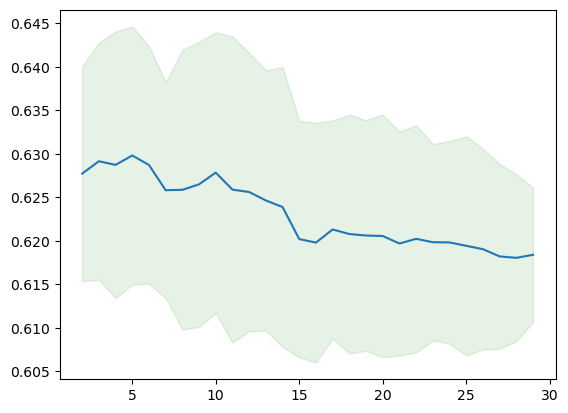

In [13]:
print('KNN results')
model_train(model, param_grid, hyperparams)

Попробуем нормализовать

In [14]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
hyperparams = list(range(2, 30))
param_grid = {'knn__n_neighbors': hyperparams}

Normalised KNN results
Best params: {'knn__n_neighbors': 29}
              precision    recall  f1-score   support

          -1       0.84      0.94      0.89      8550
           1       0.74      0.48      0.58      2960

    accuracy                           0.82     11510
   macro avg       0.79      0.71      0.73     11510
weighted avg       0.81      0.82      0.81     11510
               precision    recall  f1-score   support

          -1       0.83      0.94      0.88      2857
           1       0.70      0.43      0.53       980

    accuracy                           0.81      3837
   macro avg       0.76      0.68      0.71      3837
weighted avg       0.80      0.81      0.79      3837

0.7103846609767662 0.6841397427014207


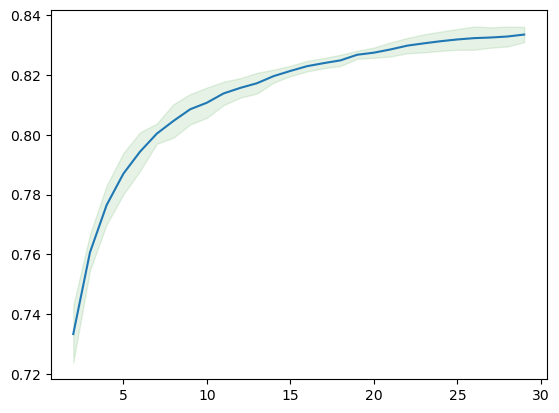

In [15]:
print('Normalised KNN results')
model_train(model, param_grid, hyperparams)

**SGDClassifier**

In [16]:
model = SGDClassifier()
hyperparams = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'loss': hyperparams}

SGD results
Best params: {'loss': 'log_loss'}
              precision    recall  f1-score   support

          -1       0.79      0.95      0.86      8550
           1       0.67      0.27      0.39      2960

    accuracy                           0.78     11510
   macro avg       0.73      0.61      0.63     11510
weighted avg       0.76      0.78      0.74     11510
               precision    recall  f1-score   support

          -1       0.80      0.96      0.87      2857
           1       0.71      0.29      0.41       980

    accuracy                           0.79      3837
   macro avg       0.76      0.63      0.64      3837
weighted avg       0.78      0.79      0.75      3837

0.6123865971234392 0.6254571657154286


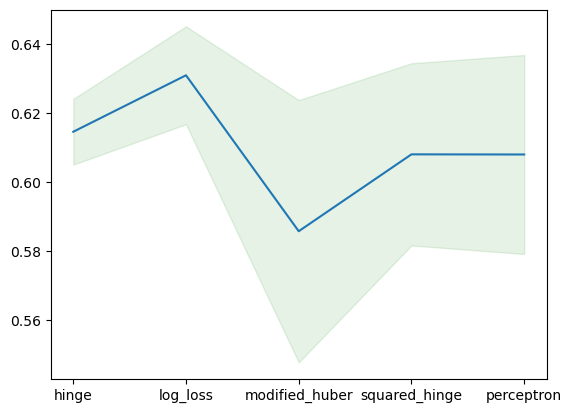

In [17]:
print('SGD results')
model_train(model, param_grid, hyperparams)

Попробуем нормализовать

In [18]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('sgd', SGDClassifier())
])
hyperparams = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'sgd__loss': hyperparams}

Normalised SGD results
Best params: {'sgd__loss': 'log_loss'}
              precision    recall  f1-score   support

          -1       0.81      0.96      0.88      8550
           1       0.74      0.34      0.46      2960

    accuracy                           0.80     11510
   macro avg       0.77      0.65      0.67     11510
weighted avg       0.79      0.80      0.77     11510
               precision    recall  f1-score   support

          -1       0.81      0.96      0.88      2857
           1       0.75      0.34      0.47       980

    accuracy                           0.80      3837
   macro avg       0.78      0.65      0.67      3837
weighted avg       0.79      0.80      0.77      3837

0.6476064880670144 0.6508071832163036


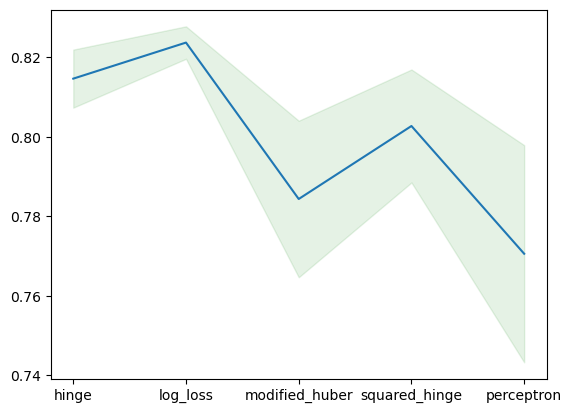

In [19]:
print('Normalised SGD results')
model_train(model, param_grid, hyperparams)

hinge - это SVM, log - логистическая регрессия, modified_huber - сглаженный SVM, squared_hinge - SVM, который штрафуется квадратично, perceptron - алгоритм перцептрона (Розенблатт). 

Гиперпараметры для остальных алгоритмов попробуйте подобрать сами. Нам осталось посмотреть:

- LogisticRegression
- SVC
- Naive Bayes

In [ ]:
# your code here

Также можете попробовать поработать с категориальными признаками. 

In [ ]:
# your code here

#### Смешивание моделей

Во всех предыдущих пунктах мы получили много хороших моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и логистическая регрессия). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберем из построенных моделей двух предыдущих пунктов две (обозначим их $clf_1$ и $clf_2$). Далее построим новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

In [20]:
model1 = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=29))
])
model2 = Pipeline([
    ('scale', StandardScaler()),
    ('sgd', SGDClassifier(loss='log_loss'))
])
model1.fit(Xtrain, ytrain)
model2.fit(Xtrain, ytrain)
clf1 = model1.predict_proba(Xtest)
clf2 = model2.predict_proba(Xtest)

In [21]:
scores = []
for alpha in np.arange(0.1, 1.1, 0.1):
    res = alpha * clf1 + (1 - alpha) * clf2

    pred = []
    for elem in res:
        pred.append(np.argmax(elem))
    scores.append(roc_auc_score(pred, ytest))
    
    print('alpha:', round(alpha, 1), 'score:', scores[-1])

alpha: 0.1 score: 0.8096850733390853
alpha: 0.2 score: 0.8088334801487382
alpha: 0.3 score: 0.8030408697336359
alpha: 0.4 score: 0.8051561235234703
alpha: 0.5 score: 0.8010614678748481
alpha: 0.6 score: 0.7930839666277503
alpha: 0.7 score: 0.7850330429558425
alpha: 0.8 score: 0.7794649255513975
alpha: 0.9 score: 0.7736536339442196
alpha: 1.0 score: 0.7640226615838733


# Задача 2.

Решим задачу распознавания лиц с помощью метода опорных векторов. 

In [22]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Нарисуем несколько лиц из датасета

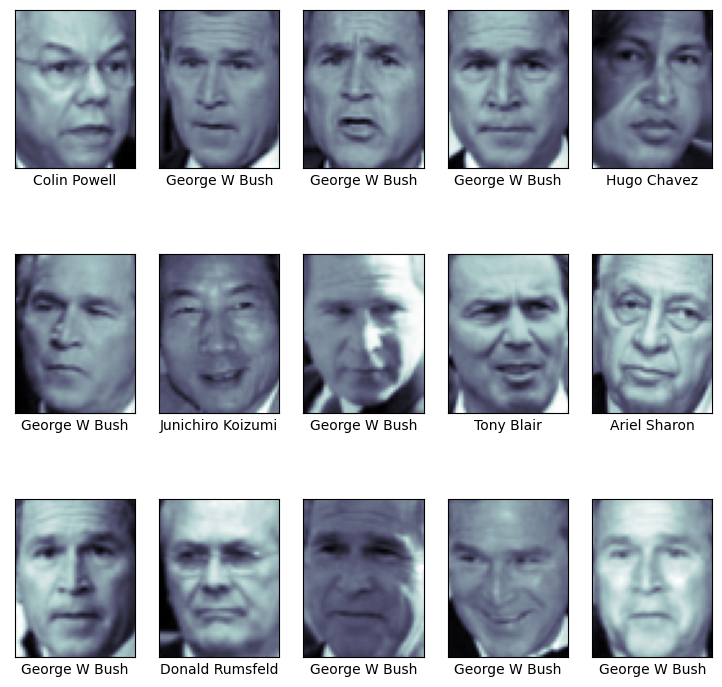

In [23]:
fig, ax = plt.subplots(3, 5, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [24]:
faces.images.shape

(1348, 62, 47)

Каждое изображение имеет размер [62×47] - это примерно 3000 пикселей. Мы можем использовать пиксели как признаки, но давайте понизим размерность пространства признаков.

Извлечем 150 самых информативных признаков из данных фотографий методом RandomizedPCA (помним, что это метод уменьшения размерности).

In [25]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA #Principal Components Analysis
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)

Попробуем решить задачу алгоритмом SVM.

In [26]:
svc = SVC(kernel='linear')

model = make_pipeline(pca, svc)

In [27]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [28]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)

print(grid.best_params_)

CPU times: user 25 s, sys: 556 ms, total: 25.6 s
Wall time: 3.23 s
{'svc__C': 1}


In [29]:
model = grid.best_estimator_

yfit = model.predict(Xtest)

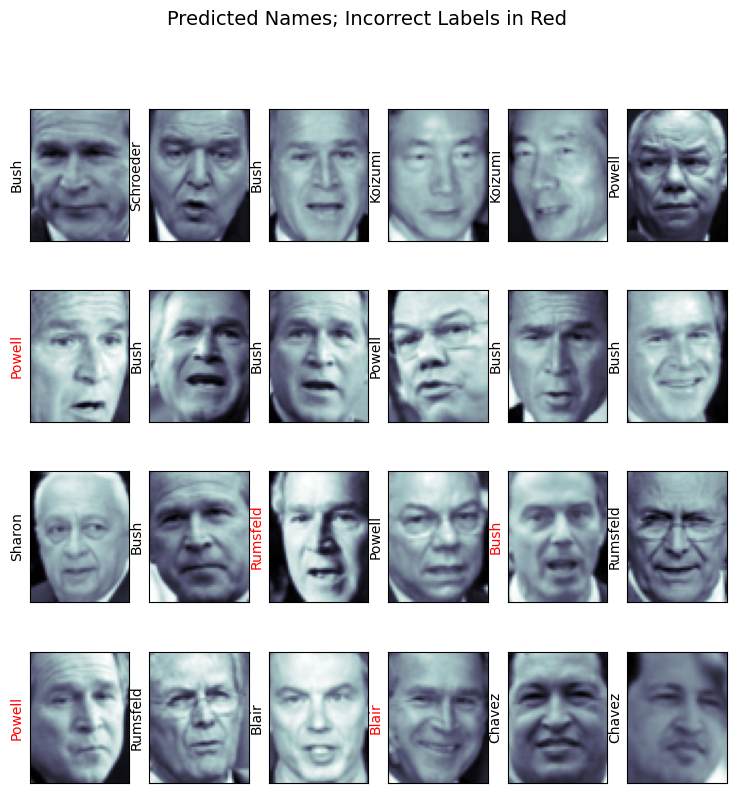

In [30]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Выведем на экран метрики классификации.

In [31]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.67      0.65        15
     Colin Powell       0.74      0.84      0.79        68
  Donald Rumsfeld       0.74      0.81      0.77        31
    George W Bush       0.85      0.79      0.82       126
Gerhard Schroeder       0.75      0.78      0.77        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      0.92      0.92        12
       Tony Blair       0.81      0.83      0.82        42

         accuracy                           0.80       337
        macro avg       0.80      0.79      0.79       337
     weighted avg       0.80      0.80      0.80       337



Нарисуем матрицу ошибок классификатора.

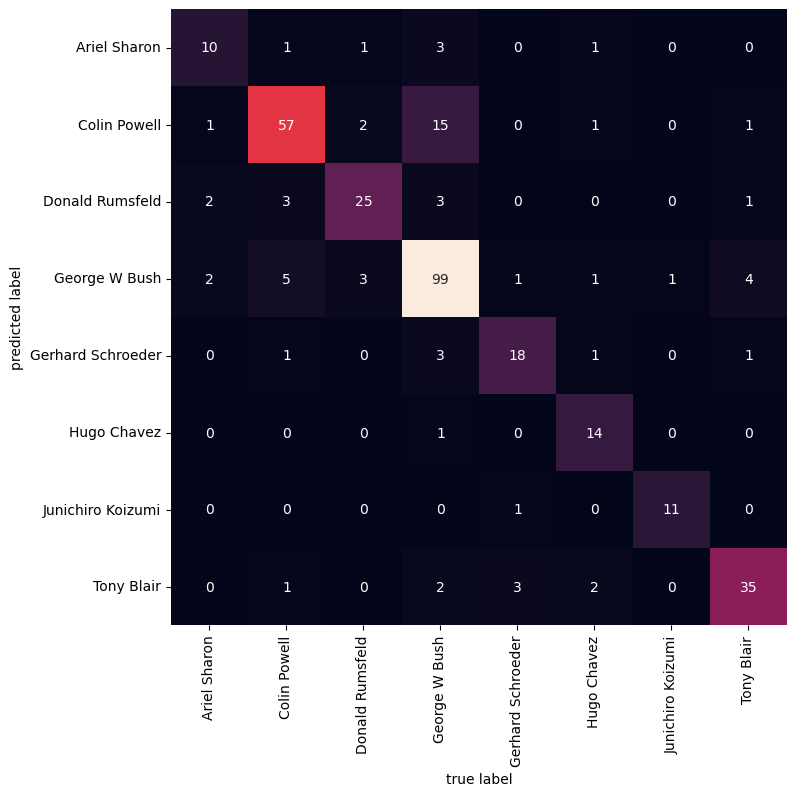

In [32]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(yfit,ytest)

0.798219584569733

## Решение нелинейных задач с помощью SVM

In [34]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

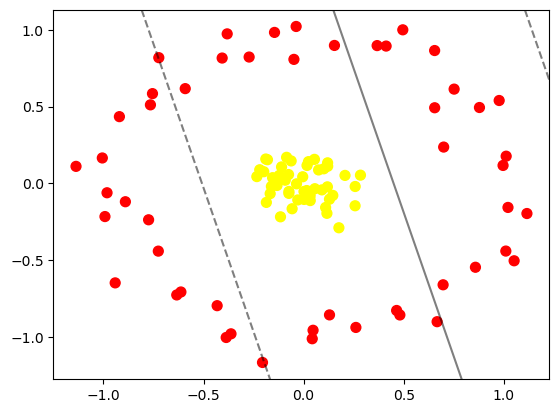

In [35]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Перейдем в пространство новой (большей) размерности. В данном примере в качестве третьей координаты можно использовать радиальную фунцию:

In [36]:
r = np.exp(-(X ** 2).sum(1))

In [38]:
from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, -45, 0, 35, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, -45, 0, 35, 90), value=-90), IntSlider(value=…

Видим, что в новом пространстве выборка стала линейно разделимой.

Решение исходной задачи в новом пространстве с помощью SVM называется ядровым SVM (Kernel SVM).

In [39]:
clf = SVC(kernel='rbf', C=1E6) #rbf = radial basis function
clf.fit(X, y)

SVC(C=1000000.0)

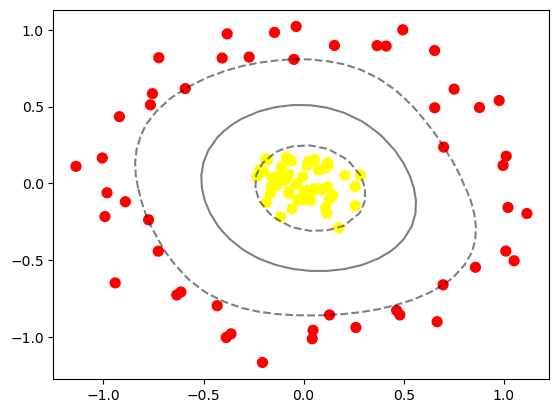

In [40]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Что-то вроде домашних заданий:

### Задание 1.

Решите задачу распознавания лиц с помощью SVM с ядром. Попробуйте различные ядра: 'poly', 'rbf', 'sigmoid'.

Подберите гиперпараметры по кросс-валидации. 

SVM с каким ядром дал лучший результат?

In [ ]:
#your code here

### Задание 2.

Решите задачу распознавания лиц с помощью логистической регрессии (она также поддерживает опцию class_weight='balanced'):

1) Объявите модель, состоящую из pipeline(pca,logistic regression)

2) Подберите по сетке параметр C логистической регрессии (с помощью GridSearch)

3) Обучите модель на тренировочных данных и выведите наилучшие параметры модели

Какое качество показала эта модель?

In [ ]:
from sklearn.linear_model import LogisticRegression

#your code here

lr = ...
model = make_pipeline(...)

param_grid = ...
grid = GridSearchCV(model, param_grid)

...

### Задание 3.

Сгенерируйте 100 точек для задачи двухклассовой классификации с помощью датасета make_moons https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html.

Используйте параметр noise=0.1.

Подберите тип ядра в методе SVM и значение параметра C, чтобы добиться (визуально) безошибочной классификации.

In [ ]:
from sklearn.datasets import make_moons

#your code here